In [1]:
import pandas as pd
import numpy as np
import os 
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

2025-10-24 12:37:53.705319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-24 12:37:53.722808: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-24 12:37:53.728429: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-24 12:37:53.741932: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-24 12:37:54.523804: W tensorflow/compiler/tf2

In [2]:
df = pd.read_csv("train_df_features.csv")


In [6]:
Columns_thm = [column for column in df.columns if column.startswith("thm_")]
print(df[Columns_thm])


            thm_1      thm_2      thm_3      thm_4      thm_5
0       23.961756  23.814337  24.226456  24.972145  24.151730
1       23.901178  23.906971  23.996599  24.891283  24.180458
2       23.930208  23.978413  23.933828  24.954830  24.221441
3       23.967825  23.814337  23.936724  25.020044  24.188141
4       24.005043  23.838219  23.936348  24.911190  24.270817
...           ...        ...        ...        ...        ...
457213  29.329695  27.966221  27.857061  30.359417  29.501087
457214  29.370110  28.101042  27.965866  30.417227  29.244358
457215  29.458855  28.060148  27.893045  30.340141  29.244358
457216  29.789215  28.434057  28.046608  30.397961  28.868093
457217  29.696465  28.388973  27.965866  30.424807  28.860228

[457218 rows x 5 columns]


In [17]:
thm_Cols = Columns_thm
columns_targets_gestures = [
    "Above ear - pull hair",
    'Cheek - pinch skin',
     'Eyebrow - pull hair',
    'Eyelash - pull hair',
    'Forehead - pull hairline',
    'Forehead - scratch',
    'Neck - pinch skin',
    'Neck - scratch',
]  
columns_non_gestures = [
            'Write name on leg',
            'Wave hello',
            'Glasses on/off',
            'Text on phone',
            'Write name in air',
            'Feel around in tray and pull out an object',
            'Scratch knee/leg skin',
            'Pull air toward your face',
            'Drink from bottle/cup',
            'Pinch knee/leg skin'
        ]

df['label_collapsed'] = df['gesture'].apply(
    lambda x: x if x in columns_targets_gestures else 'non_target'
)

n_samples = min(len(df), len(thm_Cols))
label_col = df['label_collapsed'].iloc[:n_samples].values

In [18]:
X, y = [], []

for seq_id, group in df.groupby("sequence_id"):
    X.append(group[rows_thm].values)
    y.append(group['label_collapsed'].iloc[0])
    

In [19]:
max_len_sequences = int(np.percentile([len(seq) for seq in X], 95))
X_padded = pad_sequences(X, maxlen=max_len_sequences, dtype='float32', padding='post', truncating='post')

label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded, num_classes=9)

print(f"X_pad shape: {X_padded.shape}")
print(f"y_Categorical shape: {y_categorical.shape}")

X_pad shape: (7573, 115, 5)
y_Categorical shape: (7573, 9)


In [20]:
def LSTM_RNN_THM_model(input_shape=(None, 5), num_classes=9):
    inputs = keras.layers.Input(shape = input_shape)

    x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(inputs)
    x = keras.layers.Dropout(0.30)(x)
    x = keras.layers.LSTM(64)(x)
    x = keras.layers.Dropout(0.30)(x)

    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.30)(x)

    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    model = keras.models.Model(inputs, outputs)

    return model
    

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_padded, y_categorical, test_size=0.20, shuffle=False
)

print(f"X train shape: {X_train.shape}")
print(f"Y train shape: {Y_train.shape}")
print(f"X test shape: {X_test.shape}")
print(f"Y test shape: {Y_test.shape}")

X train shape: (6058, 115, 5)
Y train shape: (6058, 9)
X test shape: (1515, 115, 5)
Y test shape: (1515, 9)


In [22]:
model = LSTM_RNN_THM_model(input_shape=(max_len_sequences, len(rows_thm)))


2025-10-24 12:41:58.672127: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [23]:
optimizers = keras.optimizers.AdamW(learning_rate=1e-4, clipnorm=1.0)

model.compile(
    optimizer=optimizers,
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

history = model.fit(
    X_train, Y_train, validation_data=(X_test, Y_test), batch_size=32, epochs=50
)

model.summary()

Epoch 1/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 34s 159ms/step - accuracy: 0.1603 - loss: 2.4466 - val_accuracy: 0.3518 - val_loss: 2.1377
Epoch 2/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 29s 154ms/step - accuracy: 0.2514 - loss: 2.2816 - val_accuracy: 0.3505 - val_loss: 2.0871
Epoch 3/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 29s 153ms/step - accuracy: 0.3035 - loss: 2.2069 - val_accuracy: 0.3485 - val_loss: 2.0539
Epoch 4/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 29s 152ms/step - accuracy: 0.3267 - loss: 2.1645 - val_accuracy: 0.3459 - val_loss: 2.0457
Epoch 5/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 28s 150ms/step - accuracy: 0.3492 - loss: 2.0012 - val_accuracy: 0.3881 - val_loss: 1.7818
Epoch 6/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 29s 154ms/step - accuracy: 0.3675 - loss: 1.8733 - val_accuracy: 0.3875 - val_loss: 1.7404
Epoch 7/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 29s 151ms/step - accuracy: 0.4000 - loss: 1.7626 - val_accuracy: 0.3756 - val_loss: 1.8071
Epoch 8/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 29s 153ms/step - accuracy: 0.3982 - loss: 1

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 115, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 115, 256)       │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 115, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 687,645 (2.62 MB)

 Trainable params: 229,129 (895.04 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 458,260 (1.75 MB)

In [24]:
train_loss , train_accuracy = model.evaluate(X_train,Y_train)
test_loss , test_accuracy = model.evaluate(X_test,Y_test)

print(f"The train accuracy {train_accuracy}")
print(f"The test accuracy {test_accuracy}")

model.save("THM_RNN_LSTM.h5")

190/190 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.4836 - loss: 1.4423
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.4670 - loss: 1.4788


The train accuracy 0.48398810625076294
The test accuracy 0.4653465449810028


/tmp/ipykernel_4040805/974158325.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
/tmp/ipykernel_4040805/974158325.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

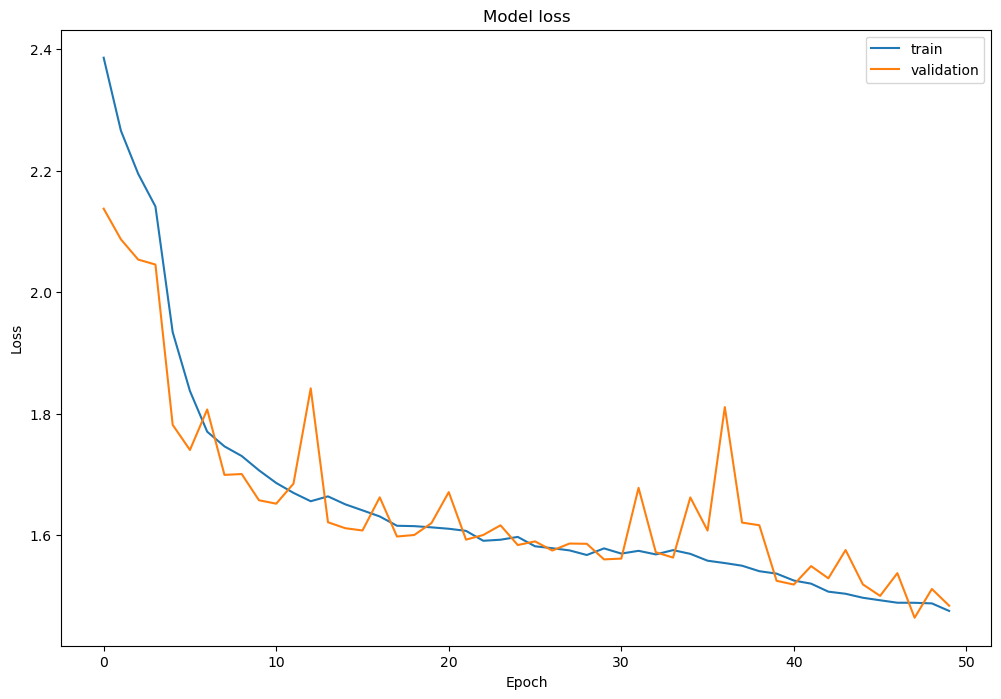

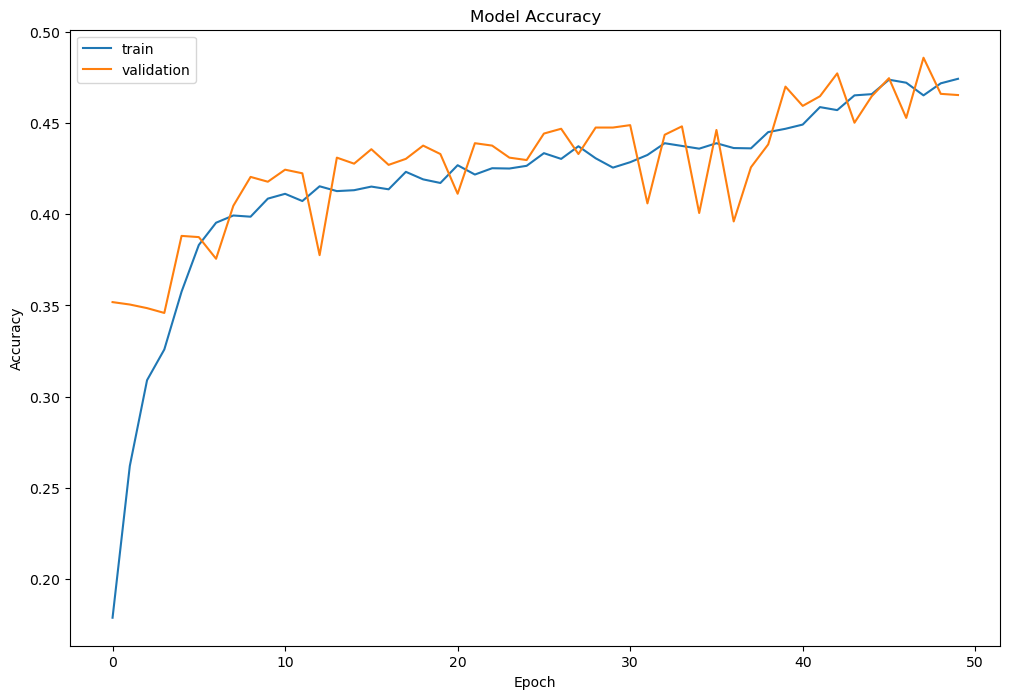

In [25]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')